In [1]:
import numpy as np
import torch
from tqdm.notebook  import tqdm
import pickle
import copy
from pprint import pprint

from jeffutils.utils import reimport
from models.pytorch_model import OrigamiNetwork
reimport("from models.pytorch_model import OrigamiNetwork", globals())
from vis_helpers import *
reimport("from vis_helpers import *", globals())

### Data

In [2]:
def layer_sam(D, n):
    scales = (D@n)/np.dot(n, n)
    mask = scales > 1
    return D + mask[:,np.newaxis] * (2*n - (2 * np.outer(scales, n)))
fv1 = np.array([0,.5])
size = 10
X1, X2 = np.meshgrid(np.linspace(-2,2,size), np.linspace(-2,2,size))
sandwichX = np.concatenate((X1.reshape(-1,1), X2.reshape(-1,1)), axis=1)
sandwichY = layer_sam(sandwichX, fv1)[:,1] > -.5
# plt.scatter(sandwichX[:,0], sandwichX[:,1], c=sandwichY)
sandwichX = torch.tensor(sandwichX, dtype=torch.float32)
sandwichY = torch.tensor(sandwichY, dtype=torch.float32)

size = 30
x1 = np.linspace(-2,2,size)
x2 = np.linspace(-2,2,size)
X1,X2 = np.meshgrid(x1,x2)
xorX = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
xorY = np.array([[1 if (i < size//2 and j < size//2 or i >= size//2 and j >= size//2) else 0 for j in range(size)] for i in range(size)]).reshape(-1)
# plt.scatter(xorX[:,0], xorX[:,1], c=xorY)
xorX = torch.tensor(xorX, dtype=torch.float32)
xorY = torch.tensor(xorY, dtype=torch.float32)

count = 20
onedX = np.linspace(-2,2,count)
onedY = np.zeros(count)
onedY[:6] = 1
onedY[-6:] = 1
onedX = np.expand_dims(onedX, axis=1)
onedX = torch.tensor(onedX, dtype=torch.float32)
onedY = torch.tensor(onedY, dtype=torch.float32)

## Training

In [4]:
test_case_x = xorX
test_case_y = xorY
print("Testing xor problem")
layers = 2
test = OrigamiNetwork(n_layers=layers, width=None, epochs=300, 
                      learning_rate=0.01, optimizer_type="adam", crease=None)
test.load_data(test_case_x, test_case_y)
# test.set_folds([np.array([-0.00466453, 0.53786325])])
test.fit()
logits = test.forward(test_case_x)

# print("\nScore =", test.score(), "after training")
print("Cut", test.get_cut_vector(), "Fold vectors", sep="\n")
pprint(test.get_fold_vectors())

Testing xor problem


Train Accuracy: 0.9567: 100%|██████████| 300/300 [00:33<00:00,  9.02it/s]

Cut
[[-7.09358   -1.3263481]
 [ 7.138072   1.494072 ]]
Fold vectors
{'Layer 0': {'crease': [10.395], 'hyperplane': [0.102, -0.088]},
 'Layer 1': {'crease': [-5.38], 'hyperplane': [0.136, 0.187]}}


In [5]:
reimport("from vis_helpers import *", globals())
gradient_landscape(test, density=62)

Gradient Layer 0: 100%|██████████| 3844/3844 [00:12<00:00, 309.95it/s]
c:\Users\dalli\source\repos\FoldAndCutNetworks\vis_helpers.py:514: RuntimeWarning: invalid value encountered in cast
  x_mesh = x_mesh.astype(np.uint8)
c:\Users\dalli\source\repos\FoldAndCutNetworks\vis_helpers.py:516: RuntimeWarning: invalid value encountered in cast
  y_mesh = y_mesh.astype(np.uint8)


Gradient Layer 1: 100%|██████████| 3844/3844 [00:13<00:00, 281.91it/s]


In [12]:
for name, param in test.named_parameters():
    if param.grad is not None:
        print(f"Gradients for {name}: {param.grad.numpy()}")

Gradients for fold_layers.0.n: [ 0.3028986  -0.15548779]
Gradients for fold_layers.0.crease: [-0.54524326]
Gradients for fold_layers.1.n: [-0.20245288  3.5092182 ]
Gradients for fold_layers.1.crease: [0.02899822]
Gradients for output_layer.weight: [[-0.10891609 -0.06118248]
 [ 0.10891609  0.06118247]]
Gradients for output_layer.bias: [ 0.13842513 -0.13842513]


In [7]:
reimport("from vis_helpers import *", globals())
folds, cuts, creases, trains, vals = test.get_history()
for l in range(layers):
    plot_wiggles(fold_histories=folds, crease_histories=creases, train_histories=trains, layer=l)

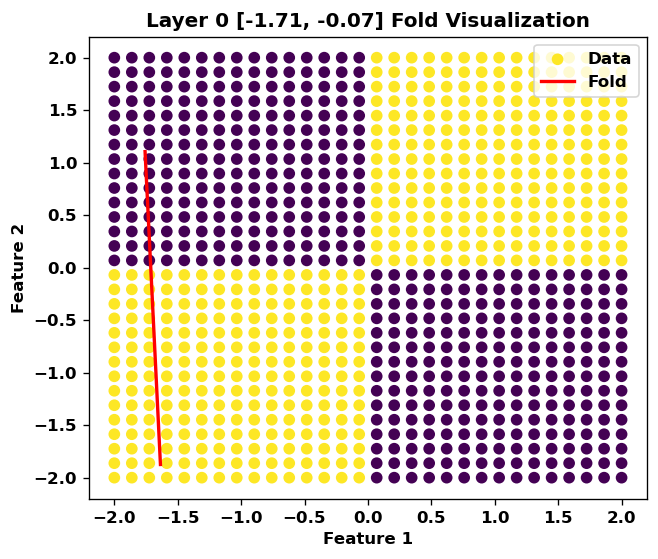

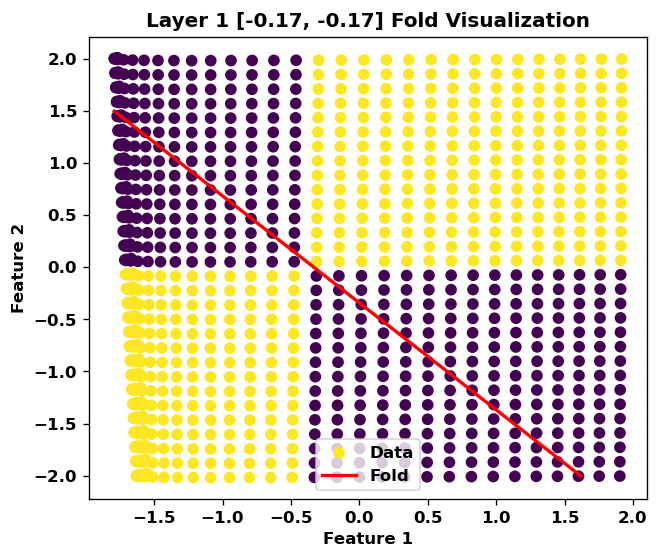

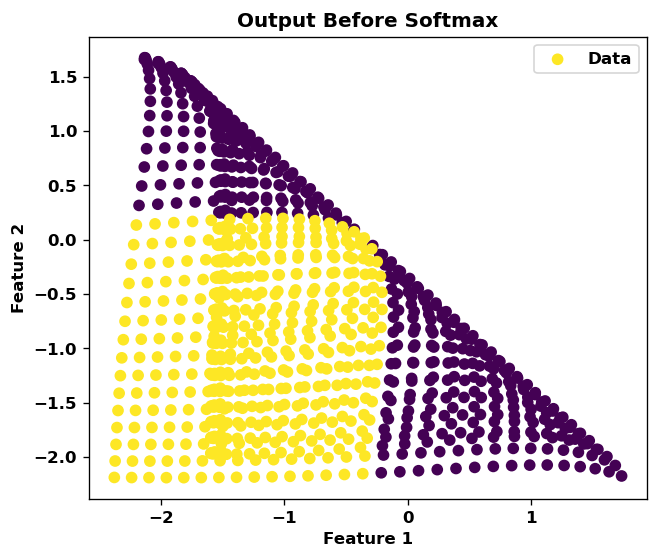

In [8]:
# Visualize folds at each layer
# reimport("from models.pytorch_model_old import OrigamiNetwork", globals())
# reimport("from vis_helpers import *", globals())
for layer_index in range(layers+1):
    plot_folds(test, layer_index=layer_index, use_plotly=False)

Plotting: 100%|██████████| 50/50 [00:00<00:00, 1110.46it/s]


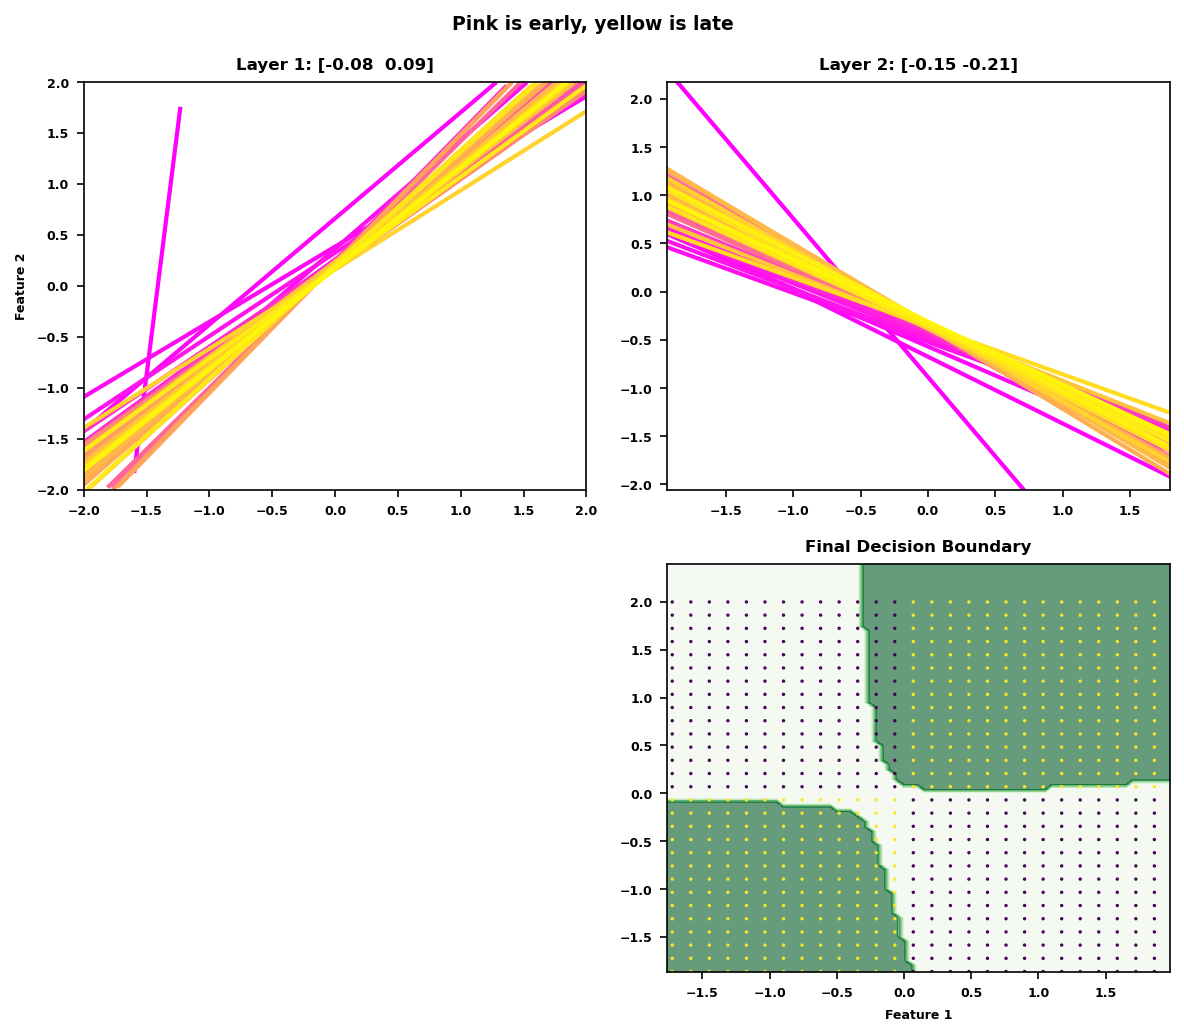

In [6]:
reimport("from vis_helpers import *", globals())
plot_history(test, verbose=2)

In [7]:
pprint(test.get_fold_vectors())

{'Layer 0': {'crease': [7.801], 'hyperplane': [-0.086, 0.075]},
 'Layer 1': {'crease': [3.739], 'hyperplane': [-0.147, -0.215]}}


In [8]:
reimport("from vis_helpers import *", globals())
max_score, best_folds = create_landscape(test, landscape_type="Loss", density=61, verbose=1)

Loss Layer 0: 100%|██████████| 3721/3721 [00:05<00:00, 711.47it/s] 


Loss Layer 1: 100%|██████████| 3721/3721 [00:04<00:00, 774.88it/s]
